# Project 2 Assignment

## Assignment Overview & Instructions

The objective of Project 2 is to extract time series features for human activity
monitoring.

### Dataset
The following [link](https://www.uni-mannheim.de/dws/research/projects/activity-recognition/#dataset_realworld) provides human activity data for 15 subjects. Click on each subject to
access the time series data.   
For this project consider accelerometer data for all the 15
subjects for walking, running, climbing up and climbing down for chest sensor only.

### Task 1: Load the data

You might find downloading the dataset from [here](https://drive.google.com/drive/folders/1JneWV9NL1v2R8LpiTNKw2oqTgd3o2Sgx) more convenient.

In [49]:
# YOUR CODE HERE
import pandas as pd


file_number = range(1,16)
activity_name = ["climbingdown", "climbingup", "running", "walking"]

all_data = []

for i in file_number:
    for activity in activity_name:
        file_name = f"s{i}_acc_{activity}_{activity}_chest.csv"

        df = pd.read_csv(file_name)
        df['subject'] = i
        df['activity'] = activity
        all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)
combined_df

,id,attr_time,attr_x,attr_y,attr_z,subject,activity
0,1,1435996968010,5.616797,8.064270,0.878073,1,climbingdown
1,2,1435996968032,5.589264,8.054693,0.869095,1,climbingdown
2,3,1435996968052,5.580884,8.060080,0.908001,1,climbingdown
3,4,1435996968073,5.588067,8.033744,0.884657,1,climbingdown
4,5,1435996968093,5.583877,8.060678,0.875679,1,climbingdown
...,...,...,...,...,...,...,...
1752354,33213,1437229289900,0.532710,9.598953,-1.486799,15,walking
1752355,33214,1437229289920,0.586579,9.662998,-1.464653,15,walking
1752356,33215,1437229289993,0.578798,9.689933,-1.492186,15,walking
1752357,33216,1437229289994,0.594959,9.598354,-1.548450,15,walking


### Task 2: Feature Extraction
Compute permutation entropy and complexity across all parameter combinations:
- Dimensions: 3, 4, 5, 6
- Delays: 1, 2, 3
- Signal lengths: 1024, 2048, 4096
- All three axes (x, y, z)

**Sample output table**

|   |   |   |   |   |   |   |   |
|---|---|---|---|---|---|---|---|
| Subject  | Accelerometer axis   | Signal length  | Dimension  | Delay  | Permutation entropy  | Complexity  | Activity  |
| 1 to 15  | x or y or z  | 1024 or 2048 or 4096  | 3 or 4 or 5 or 6  | 1 or 2 or 3  |   |   | Walking or running or climbing up or climbing down  |

This table/dataframe is expected to have 6480 rows.

In [59]:
# YOUR CODE HERE
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
from itertools import permutations
from collections import Counter
import itertools
import math

def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    '''
    Computes the ordinal patterns of a time series for a given embedding dimension and delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS:
        ts        = numeric vector representing the time series
        embdim    = embedding dimension (3 <= embdim <= 7 preferred range)
        embdelay  = embedding delay
    OUTPUT:
        A numeric vector representing frequencies of ordinal patterns
    '''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i * t)
    partition = tmp[(t * (m - 1)):, :]

    permutation = np.argsort(partition, axis=1)

    # You need a custom hash function to convert permutations to unique indices
    def _hash(permutation):
        # Convert each permutation row to a unique number in [0, m! - 1]
        factorials = np.array([math.factorial(i) for i in range(m)], dtype=int)
        indices = np.zeros(permutation.shape[0], dtype=int)
        for i in range(permutation.shape[0]):
            rank = 0
            for j in range(m):
                smaller = np.sum(permutation[i, j+1:] < permutation[i, j])
                rank += smaller * math.factorial(m - j - 1)
            indices[i] = rank
        return indices

    idx = _hash(permutation)

    counts = np.zeros(math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()

    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])


def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0])

In [92]:
dimensions = [3, 4, 5, 6]
delays = [1, 2, 3]
lengths = [1024, 2048, 4096]
axes_map = {
    'x': 'attr_x',
    'y': 'attr_y',
    'z': 'attr_z'
}

param_grid = list(itertools.product(dimensions, delays, lengths, axes))

In [102]:
results = []

for subject_id in combined_df['subject'].unique():
    subj_df = combined_df[combined_df['subject'] == subject_id]
    
    for activity in subj_df['activity'].unique():
        act_df = subj_df[subj_df['activity'] == activity]
        
        for (m, tau, L, axes) in param_grid:
            col_name = axes_map[axes]
        
            signal = combined_df[col_name].values[:L]
        
            p = ordinal_patterns(signal, m, tau)
            H = p_entropy(p)
            C = complexity(p)
        
            results.append({
                'Subject': subject_id,
                'Accelerometer axes': axes,
                'Signal length': L,
                'Dimension': m,
                'Delay': tau,
                'Permutation entropy': round(H, 4),
                'Complexity': round(C, 4),
                'Activity': activity
            })

df_results = pd.DataFrame(results)

df_results

,Subject,Accelerometer axes,Signal length,Dimension,Delay,Permutation entropy,Complexity,Activity
0,1,x,1024,3,1,0.8639,0.1138,climbingdown
1,1,y,1024,3,1,0.8712,0.1093,climbingdown
2,1,z,1024,3,1,0.8664,0.1121,climbingdown
3,1,x,2048,3,1,0.8152,0.1472,climbingdown
4,1,y,2048,3,1,0.8328,0.1358,climbingdown
...,...,...,...,...,...,...,...,...
6475,15,y,2048,6,3,0.9485,0.1049,walking
6476,15,z,2048,6,3,0.9749,0.0568,walking
6477,15,x,4096,6,3,0.9371,0.1310,walking
6478,15,y,4096,6,3,0.9442,0.1188,walking


### Task 3: Focus Your Analysis

Now select one particular subject of your choice (e.g 3), a particular attribute of your choice (e.g x) and a particular Signal length (e.g 2048) and filter the data for these specifics. You are only requited to filter the required data here. In the tasks 4 and 5, you will focus your analysis on this partcular subject for the specified accelerometer axis and signal length.



In [104]:
# YOUR CODE HERE

subject_choice = 3
axis_choice = 'x'
signal_length_choice = 2048

filtered_df = df_results[
    (df_results['Subject'] == subject_choice) &
    (df_results['Accelerometer axes'] == axis_choice) &
    (df_results['Signal length'] == signal_length_choice)
]

filtered_df


,Subject,Accelerometer axes,Signal length,Dimension,Delay,Permutation entropy,Complexity,Activity
867,3,x,2048,3,1,0.8152,0.1472,climbingdown
876,3,x,2048,3,2,0.9327,0.0603,climbingdown
885,3,x,2048,3,3,0.9723,0.0259,climbingdown
894,3,x,2048,4,1,0.7437,0.2252,climbingdown
903,3,x,2048,4,2,0.8983,0.1139,climbingdown
912,3,x,2048,4,3,0.9548,0.0564,climbingdown
921,3,x,2048,5,1,0.7245,0.2774,climbingdown
930,3,x,2048,5,2,0.8762,0.1753,climbingdown
939,3,x,2048,5,3,0.9412,0.0963,climbingdown
948,3,x,2048,6,1,0.7696,0.2655,climbingdown


### Task 4: Waling vs Running

Use scatter plots to identify the optimal dimension and delay that best separate walking from running. Since you focused on a single dimension, a single subject and a single dimension, you will get 12 walking, running pairs for 4 dimensions and 3 delays, this should give rise to 12 panels, each showing a scatterplot.

After you have made the scatter plots, identify the optimum dimension and delay that provide the best separation between walking and running. Reason why this is your choice.

In [113]:
# YOUR CODE HERE

filtered_pair = filtered_df[filtered_df['Activity'].isin(['walking', 'running'])]
filtered_pair

,Subject,Accelerometer axes,Signal length,Dimension,Delay,Permutation entropy,Complexity,Activity
1083,3,x,2048,3,1,0.8152,0.1472,running
1092,3,x,2048,3,2,0.9327,0.0603,running
1101,3,x,2048,3,3,0.9723,0.0259,running
1110,3,x,2048,4,1,0.7437,0.2252,running
1119,3,x,2048,4,2,0.8983,0.1139,running
1128,3,x,2048,4,3,0.9548,0.0564,running
1137,3,x,2048,5,1,0.7245,0.2774,running
1146,3,x,2048,5,2,0.8762,0.1753,running
1155,3,x,2048,5,3,0.9412,0.0963,running
1164,3,x,2048,6,1,0.7696,0.2655,running


/var/folders/z3/xf4z7gw93vx6_sjyrm3d5drh0000gn/T/ipykernel_29052/2634653532.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


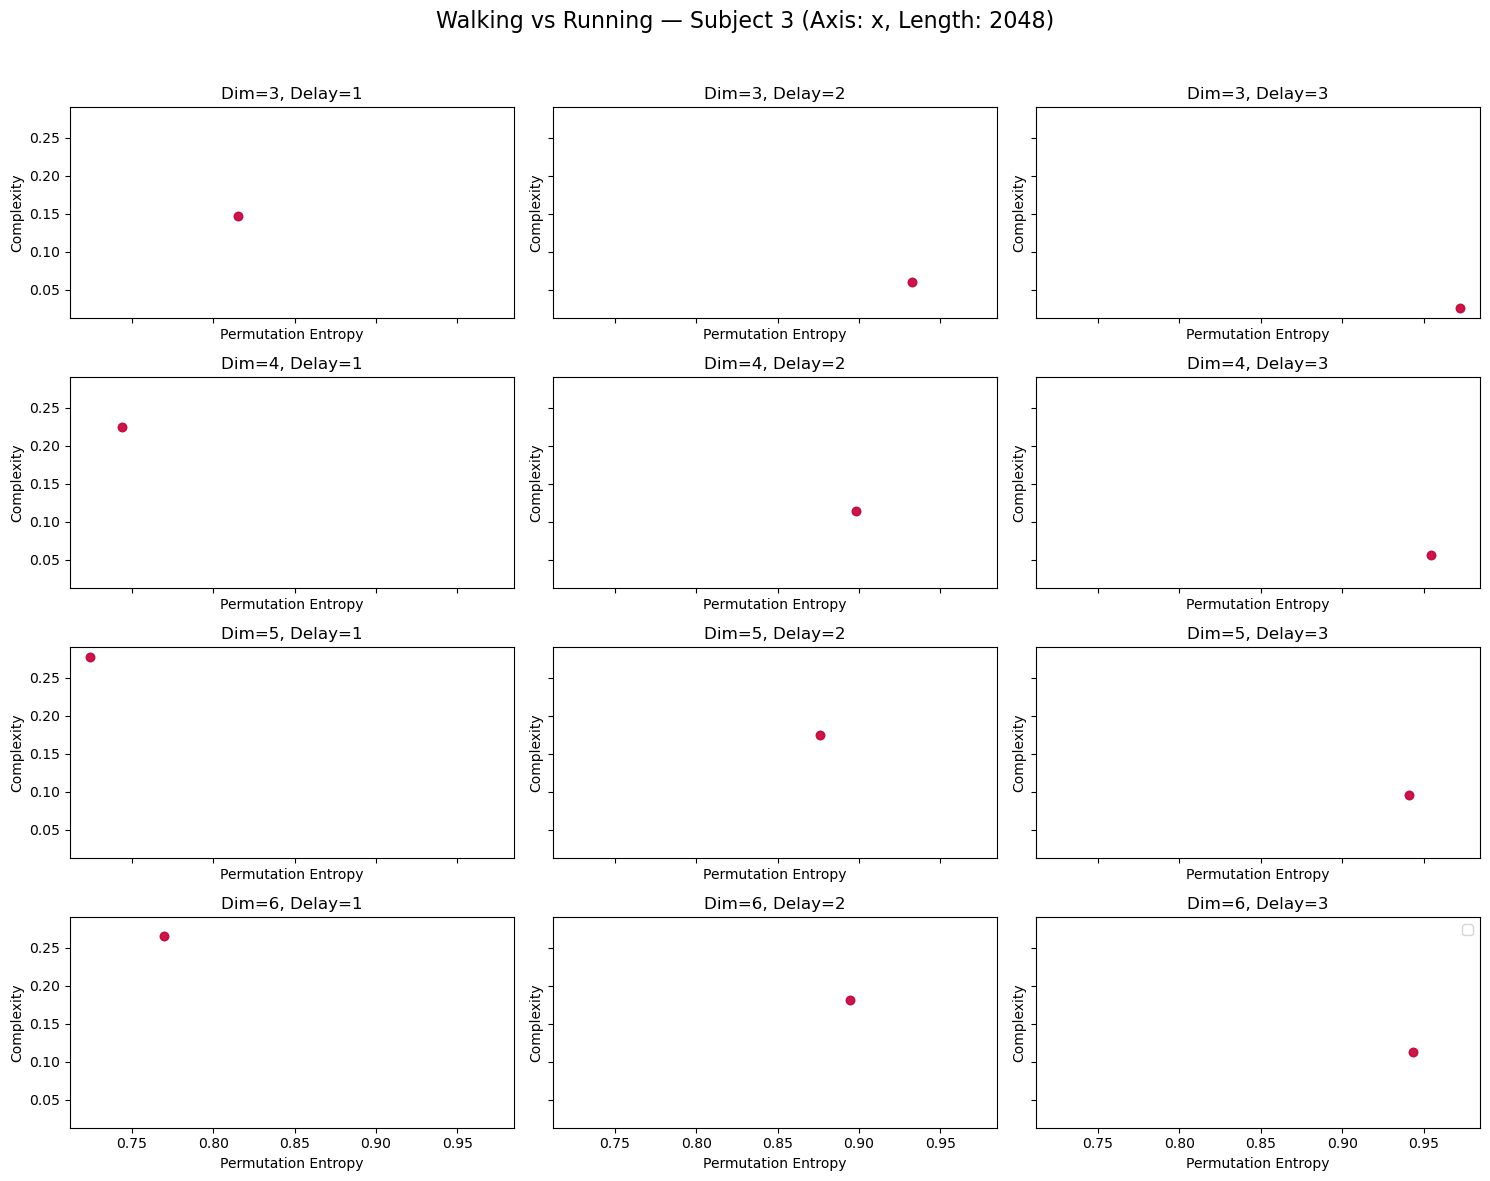

In [107]:
import matplotlib.pyplot as plt

dimensions = sorted(filtered_pair['Dimension'].unique())
delays = sorted(filtered_pair['Delay'].unique())

fig, axes = plt.subplots(len(dimensions), len(delays), figsize=(15, 12), sharex=True, sharey=True)

for i, dim in enumerate(dimensions):
    for j, delay in enumerate(delays):
        ax = axes[i, j]

        subset = filtered_pair[
            (filtered_pair['Dimension'] == dim) &
            (filtered_pair['Delay'] == delay)
        ]

        for act, color in zip(['walking', 'running'], ['blue', 'red']):
            data_act = subset[subset['Activity'] == act]
            ax.scatter(
                data_act['Permutation entropy'],
                data_act['Complexity'],
                label=act if (i == 0 and j == 0) else "",
                color=color, alpha=0.7
            )

        ax.set_title(f"Dim={dim}, Delay={delay}")
        ax.set_xlabel("Permutation Entropy")
        ax.set_ylabel("Complexity")

plt.suptitle("Walking vs Running — Subject 3 (Axis: x, Length: 2048)", fontsize=16)
plt.legend(loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


> YOUR ANSWER HERE

### Task 5: Climbing Up vs. Climbing Down

Use scatter plots similar to task 4 to identify the optimal dimension and delay that best separate climbing up from climbing down.


In [114]:
# YOUR CODE HERE
subject_choice = 3
axis_choice = 'x'
signal_length_choice = 2048

filtered_climb = df_results[
    (df_results['Subject'] == subject_choice) &
    (df_results['Accelerometer axes'] == axis_choice) &
    (df_results['Signal length'] == signal_length_choice) &
    (df_results['Activity'].isin(['climbingup', 'climbingdown']))
]

filtered_climb

,Subject,Accelerometer axes,Signal length,Dimension,Delay,Permutation entropy,Complexity,Activity
867,3,x,2048,3,1,0.8152,0.1472,climbingdown
876,3,x,2048,3,2,0.9327,0.0603,climbingdown
885,3,x,2048,3,3,0.9723,0.0259,climbingdown
894,3,x,2048,4,1,0.7437,0.2252,climbingdown
903,3,x,2048,4,2,0.8983,0.1139,climbingdown
912,3,x,2048,4,3,0.9548,0.0564,climbingdown
921,3,x,2048,5,1,0.7245,0.2774,climbingdown
930,3,x,2048,5,2,0.8762,0.1753,climbingdown
939,3,x,2048,5,3,0.9412,0.0963,climbingdown
948,3,x,2048,6,1,0.7696,0.2655,climbingdown


/var/folders/z3/xf4z7gw93vx6_sjyrm3d5drh0000gn/T/ipykernel_29052/3803451557.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


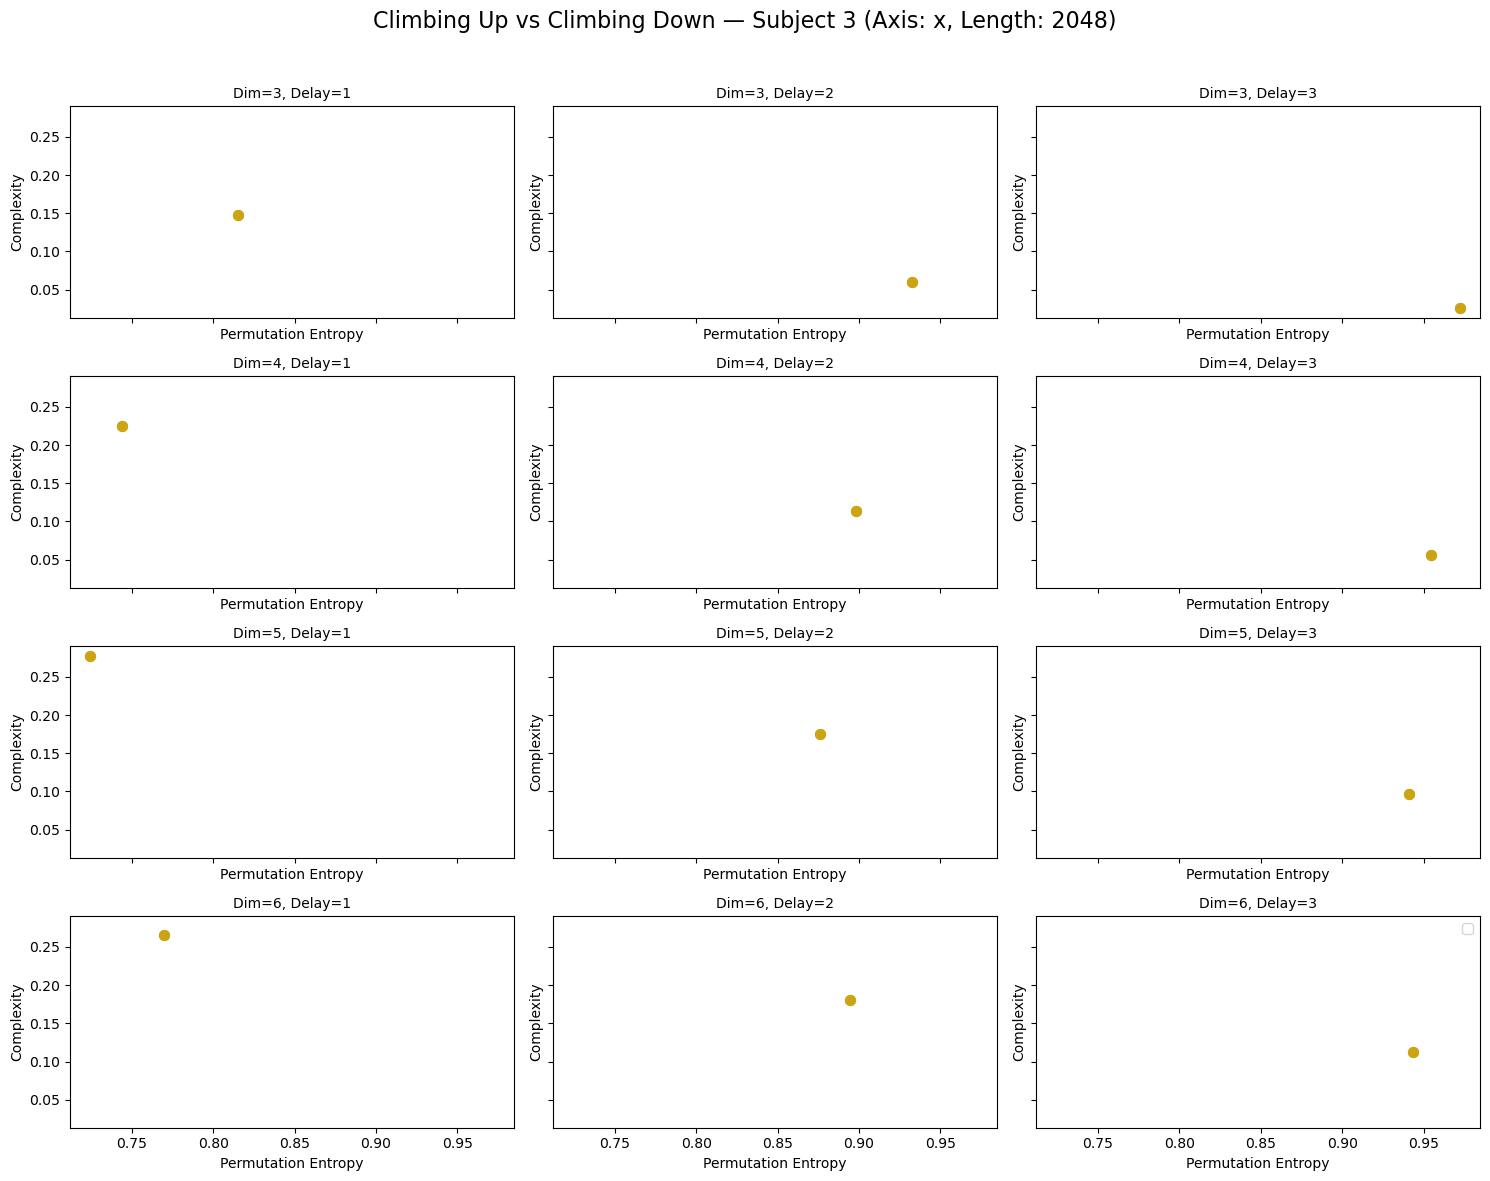

In [112]:
import matplotlib.pyplot as plt

dimensions = sorted(filtered_climb['Dimension'].unique())
delays = sorted(filtered_climb['Delay'].unique())

fig, axes = plt.subplots(len(dimensions), len(delays), figsize=(15, 12), sharex=True, sharey=True)

for i, dim in enumerate(dimensions):
    for j, delay in enumerate(delays):
        ax = axes[i, j]
        
        subset = filtered_climb[
            (filtered_climb['Dimension'] == dim) &
            (filtered_climb['Delay'] == delay)
        ]
        
        # Plot both climbing directions
        for act, color in zip(['climbingup', 'climbingdown'], ['green', 'orange']):
            data_act = subset[subset['Activity'] == act]
            ax.scatter(
                data_act['Permutation entropy'],
                data_act['Complexity'],
                label=act if (i == 0 and j == 0) else "",
                color=color, alpha=0.7, s=50
            )
        
        ax.set_title(f"Dim={dim}, Delay={delay}", fontsize=10)
        ax.set_xlabel("Permutation Entropy")
        ax.set_ylabel("Complexity")

plt.suptitle(f"Climbing Up vs Climbing Down — Subject {subject_choice} (Axis: {axis_choice}, Length: {signal_length_choice})",
             fontsize=16)
plt.legend(loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


> YOUR ANSWER HERE

## Submitting your Project

Once you've completed your project, it's time to submit your work for grading.   
This week, you will submit your code file `Project 2.ipynb` for review.  

In order to submit your work, please follow the steps below:
1. Verify you've saved your work using the `Save` button within the Jupyter Notebook 
2. Download this notebook using the `File` -> `Download As` -> Choose the `Notebook (.ipynb)` format.
3. Access the following Step 2: Submit Project 2 item.
4. Complete all prompted fields, and upload your Jupyter Notebook file (Project 2.ipynb) in the indicated field.
5. Submit your notebook to "Step 2: Submit Project 2" by the deadline indicated within your course view for the Project 2 Assignment item.

## Grading Rubric

1. Task 1 = 5 points


2. Task 2 = 35 points


3. Task 3 = 10 points


4. Task 4 = 20 points


5. Task 5 = 20 points


6. 10 points for coding consistencies (follow PeP 8 style guide for coding)

    a. Proper commenting
    
    b. Proper variable names
    
    c. Inclusion of texts in notebook to explain all the steps
    
    d. Include formulas for permutation entropy and complexity in your notebook 

    e. Inclusion of all outputs of your code

Congratulations on completing the Project 2 Assignment!